# Fisher's Linear Discriminant Analysis

## Import all Necessary Packages & Data
### This will be accomplished in order to have access to all libraries and functions.

In order to begin our project, we must import all necessary packages. In our case, these include:


- Numpy (as np): for array creation and general matrix processing
- Pandas (as pd): for DataFrame creation, fast indexing, and table visualization
- Matplotlib (as plt): for visualization and matrix displays
- Scipy.stats (as scpstats): for the use of linear algebra functions, to calculate the trim mean, and to calculate kurtosis, as well as chi2
- Sklearn.decomposition (as skdec): for the built-in PCA function
- Itertools to perform an nCk calculation
- Display to show my pseudocode

In [2]:
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt 
import scipy.stats as scpstats
import sklearn as skl
from sklearn import preprocessing
from matplotlib.patches import Ellipse
import itertools

iris_data = pd.read_csv('Data/iris.csv', skipinitialspace= True)        # Read in the CSV, skipping initial spaces in order to ensure no strange indexing calls
iris_data.head()                                                        # Display the first five rows of the data to check the DataFrame structure


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Fisher's LDA 

# Pseudocode

Here, we will define our pseudocode and algorithm for Fisher's LDA, a dimensionality reduction and feature selection technique which may prove helpful in determining, from a multivariate perspective, which features (or specific combinations of features) are most effective at describing the variance within our dataset. Fisher's LDA performs this by essentially finding a new axis which separates labeled data by its greatest between-class variance. We implement Fisher's LDA by performign the following assumptions operations:

- Assume (or create) class labels for each class within the given dataset (we will leverage sklearn's preprocessing package to accomplish this)
- Compute the mean vector for each class
- Compute the total mean vectors
- Compute within class scatter by subtracting each the class mean from each observation and multiplying by its own transpose. 
- Compute between-class scatter by subtracting the total mean vector from the class mean vectors and multiplying by its own transpose. 
- Perform eigendecomposition of Within-Class Scatter and Betwen-Class Scatter
- Output a projection matrix, composed of top eigenvectors with the largest eigenvalues.

The following image (from [this](https://stats.stackexchange.com/questions/142565/computational-complexity-for-linear-discriminant-analysis) stackExchange post) provides an excellent descriptor of the underlying formulas.

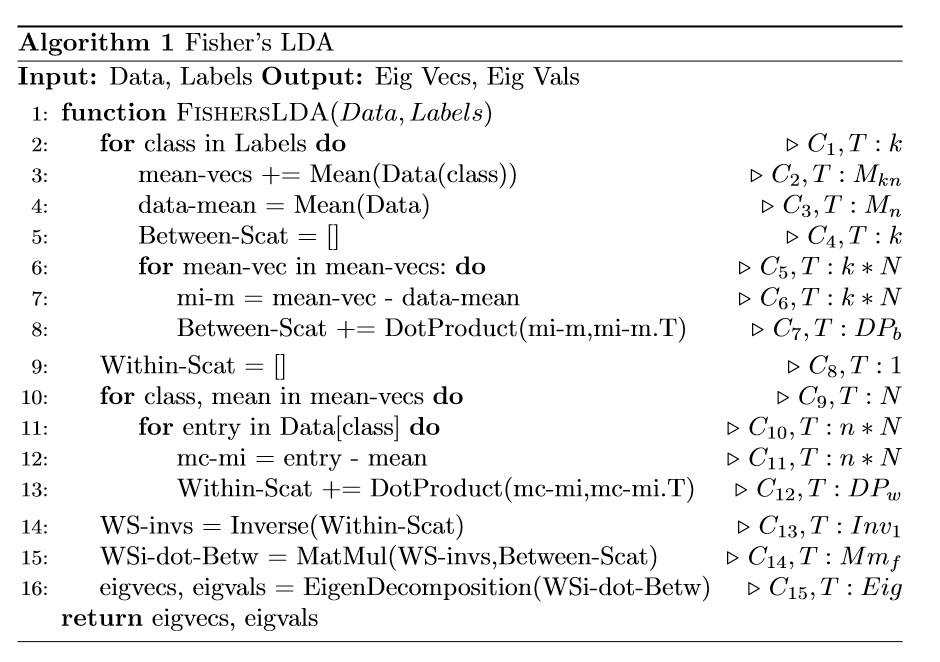

In [3]:
display.Image('Pseudocode/fisher_lda_latex_AP.jpg')

##  Time Complexity Analysis

Here, we consider costs using the following shorthand: 

- $k$ to be the number of classes
- $n$ the number of observations in our dataset
- $N$ the number of dimensions of the dataset.

It is likely easiest to consider the T(n) calculation using the documentation in the first image above, rather than in my pseudocode, as it allows us to think about T(n) using the most relevant aspects for intensive calculation.

- The within-class Scatter Matrix Multiplication (lines 9-13 in my pseudocode, the multiplication given by $DP_w$)
- The final matrix multiplication (Lines 14 and 15, $Mm_f$ in my pseudocode)
- Eigen Decomposition (Line 16, Indicated by $Eig$ in my pseudocode)

Taking these steps as the most computationally complex within my pseudocode, T(N) will be given by (using the diction in my pseudocode):

$T(n,N,k) = DP_w*C_{12} + DP_f*C_{14} + Eig*C_{15} + C_i$

Here, we can begin to break down these costs:

- $DP_w$: this dot-product requires $N(n^2)$ steps, given the way the dot-product will be formulated. (i.e. it'll take require $n^2$ operations for (mc-m)(mc-m).T)
- $Mm_F$: this matrix multiplication will have $n^3$ calculations, given the total outputting size of the formed matrices. (Note that we have not dubbed this a dot product, just because the dimensions will be different than for the other DPs)
- $Eig$: the eigen decomposition will also have to perform $n^3$ calculations. 

Therefore, dropping constants and irrelevant values, we can say that our Fisher's LDA runs in:

$O(n^3)$ time. 

## Implementation 
Here, we wil implement the pseudocode above, creating a class with two functions:

- One will prepare a dataset, leveraging sklearn's preprocessing function to create a label vector
- The other will perform Fisher's LDA on the given dataset

Our Fisher's LDA function will perform using the following methodology:

- Determine target classes
- Find and collect the mean vectors for each of the classes
- Calculate the between-class scatter (leveraging numpy's np.dot() function to perform the dot products)
- Calculate the within-class scatter (leveraging numpy's np.dot() function to perform dot products)
- Perform Matrix Multiplications and Eigenvalue decomposition (leveraging numpy's linear algebra package)

The function below will therefore:

- Take a data set and its labels as inputs (as prepared with our prep_data function)
- Output the desired eigenvectors and eigenvalues


In [4]:
class LDA:

    # Define function for data preparation
    def prep_data(cols, dataset, target_label):

        # Pre Process Labels and create numerical vectors
        temp_lbls = preprocessing.LabelEncoder()
        labels = temp_lbls.fit_transform(dataset[target_label])
        Data = dataset.drop([target_label], axis=1)
        if len(cols) > 0:
            Data = Data[cols]
        return Data.values, labels

    # Define function for LDA fitting
    def fit(self, X, y):
        target_classes = np.unique(y)
        mean_vectors = []
        
        # Calculate Mean Vectors & Reshape
        for cls in target_classes:
            mean_vectors.append(np.mean(X[y == cls], axis=0))
        data_mean = np.mean(X, axis=0).reshape(1, X.shape[1])

        # Initialize and Calculate Between class scatter
        B = np.zeros((X.shape[1], X.shape[1]))
        for i, mean_vec in enumerate(mean_vectors):
            n = X[y == i].shape[0]
            mean_vec = mean_vec.reshape(1, X.shape[1])
            mu1_mu2 = mean_vec - data_mean
            B += n * np.dot(mu1_mu2.T, mu1_mu2)
        s_matrix = []

        # Initialize and Calculate within-class scatter
        for cls, mean in enumerate(mean_vectors):
            Si = np.zeros((X.shape[1], X.shape[1]))
            for row in X[y == cls]:
                t = (row - mean).reshape(1, X.shape[1])
                Si += np.dot(t.T, t)
            s_matrix.append(Si)

        # Reshape for following operation
        S = np.zeros((X.shape[1], X.shape[1]))
        for s_i in s_matrix:
            S += s_i
        
        # Perform inverse, matmul and eigen decomposition
        S_inv = np.linalg.inv(S)
        S_inv_B = S_inv.dot(B)
        eig_vals, eig_vecs = np.linalg.eig(S_inv_B)
        idx = eig_vals.argsort()[::-1]
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx]
        return eig_vecs, eig_vals

### IV. Determine if any of the Features can Separate the Three Class Types

Here, we will attempt to run our LDA function on the **uncleaned** dataset, to attain an idea of how Fisher's LDA performs on data that has yet to have its outliers removed. We will perform this operation by: 

- Calling our LDA function on each feature combination 
- Extracting the eigenvectors and eigenvalues
- Plotting the scattered data as it appears organically
- Projecting the data onto the top eigenvector returned by Fisher's LDA
- Plotting the projected data

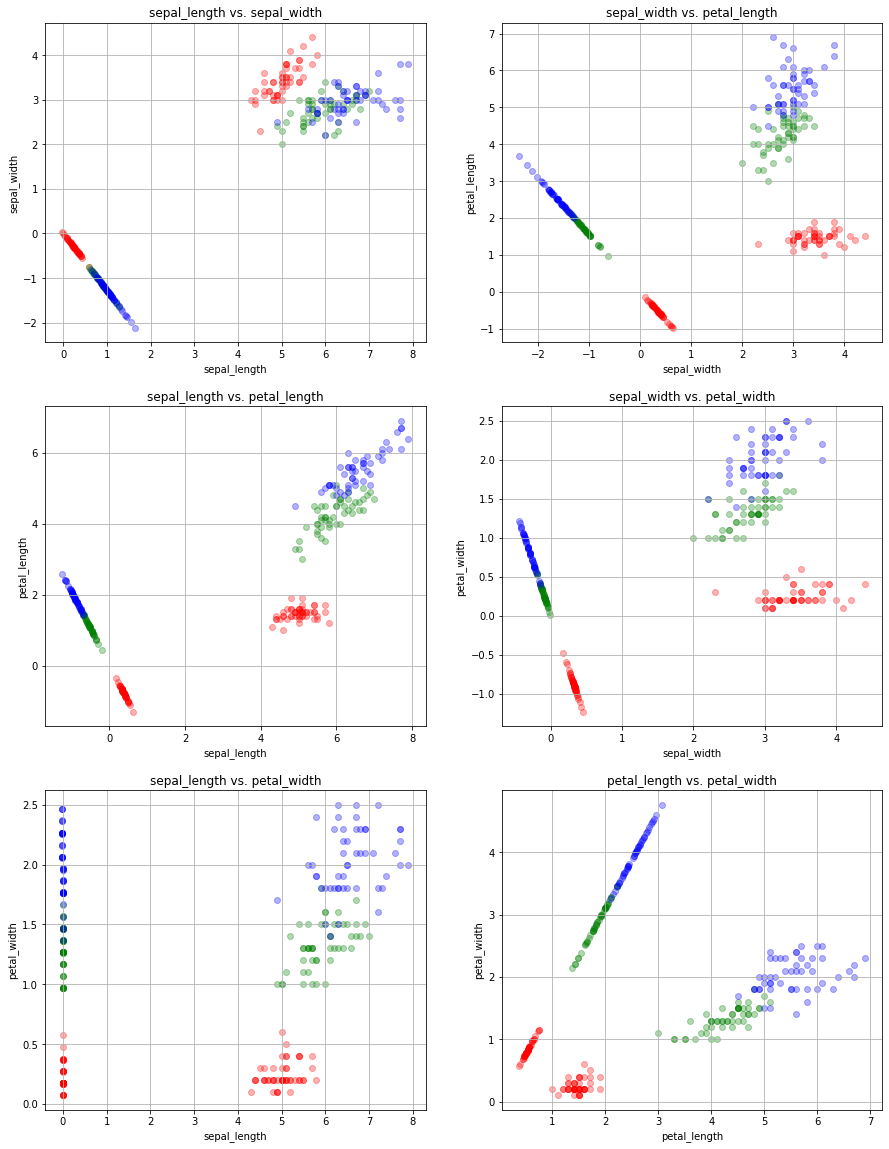

In [5]:
# Define combinations of features 
features = np.array(iris_data.drop('species', axis = 1).columns)
combo = list(itertools.combinations(features,2))

# Initialize plot
fig, ax = plt.subplots(3,2, figsize=(15,20))

# Iterate through combinations 
for i in range(len(combo)):
    if i < 3:
        axs = ax[i,0]
    else:
        axs = ax[i-3,1]
    colors = ['red', 'green', 'blue']

    # Perform LDA
    X, y = LDA.prep_data([combo[i][0], combo[i][1]], iris_data, 'species')
    lda = LDA()
    eig_vecs, eig_vals = lda.fit(X, y)

    # Extract top Eigenvector
    W = eig_vecs[:, :1]
    
    # Project along top Eigenvector and plot
    for point, pred in zip(X, y):
        axs.scatter(point[0], point[1], color=colors[pred], alpha=0.3)
        proj = (np.dot(point, W) * W) / np.dot(W.T, W)
        axs.scatter(proj[0], proj[1], color=colors[pred], alpha=0.3)
    axs.set_title(str(combo[i][0]) + ' vs. ' + str(combo[i][1]))
    axs.set_xlabel(combo[i][0])
    axs.set_ylabel(combo[i][1])
    axs.grid()
    

Our multivariate analysis is now starting to draw clear winners. In each multi-variate feature space in which it appears, **petal width** is successful at separating classes. This is a fantastic example of the descriptive power of Fisher's Linear Discriminant Analysis:

- By projecting the multivariate data into a linear space of its greatest eigenvector, we are able to determine exactly where the centers of the distributions of data lie, and which feature, if any is capable of acting as an easy distinguisher for the classes presented. 
- It is worth noting that petal length was a good separator, but combining Fisher's LDA with Mahalanobis distance was instrumental in determining that petal width was indeed a stronger feature axis along which to separate our classes. 